# Deep Learning
## Summative assessment
### Coursework 3

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
! pip install pydub==0.25.1 -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Normalization

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [3]:
ds = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=False
)

In [4]:
ds.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

In [5]:
#only take the audio
ds=ds.map(lambda t: t["audio"])
ds.element_spec

TensorSpec(shape=(None,), dtype=tf.int64, name=None)

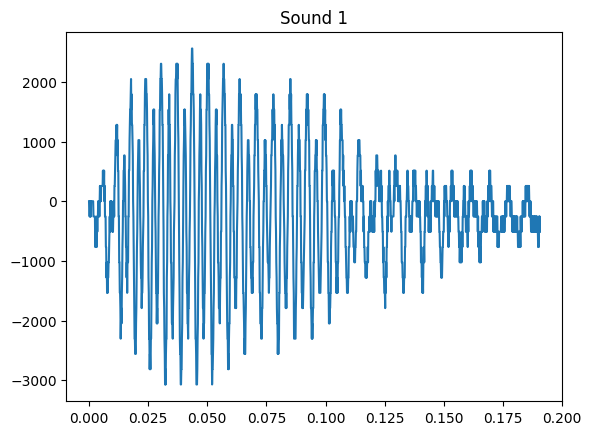

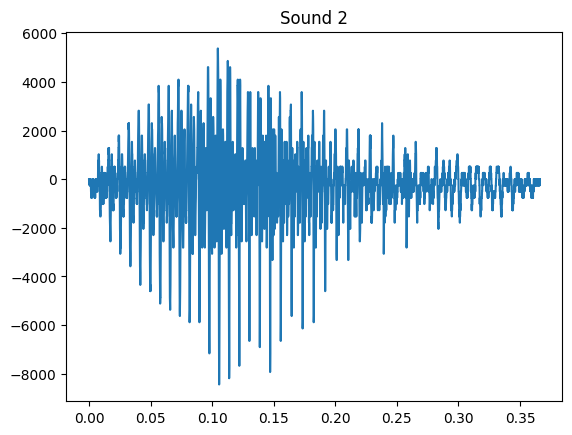

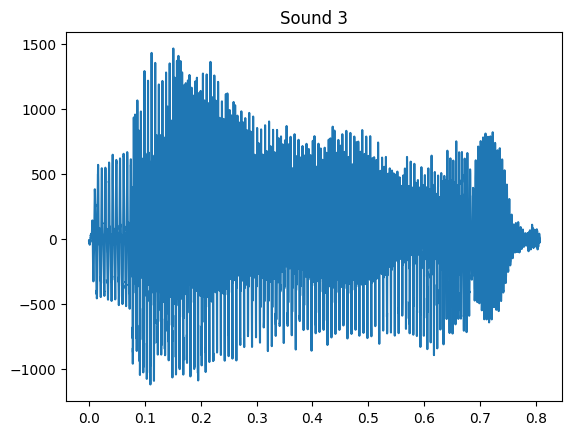

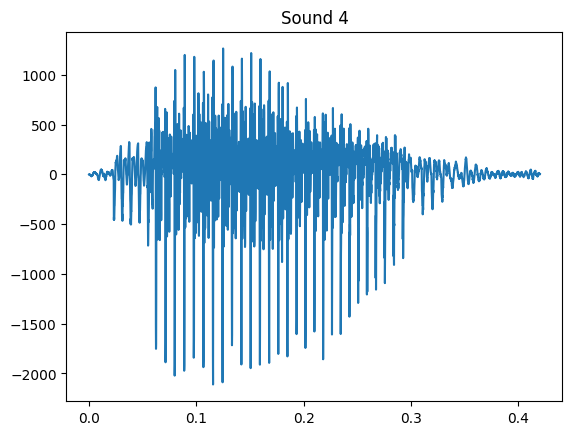

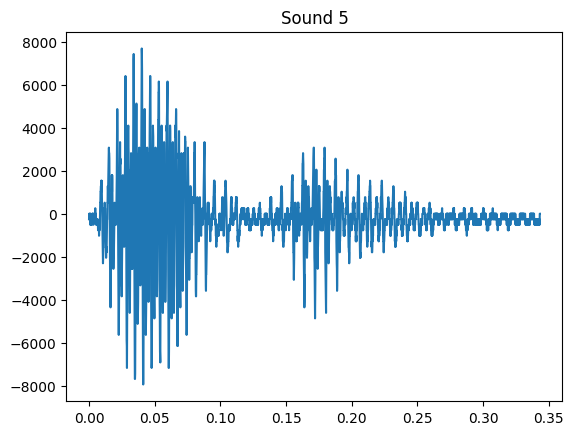

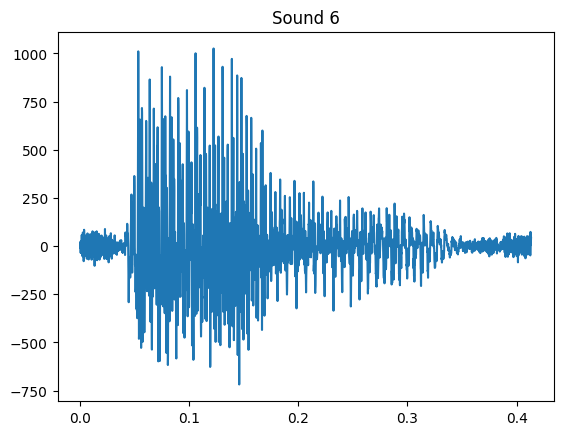

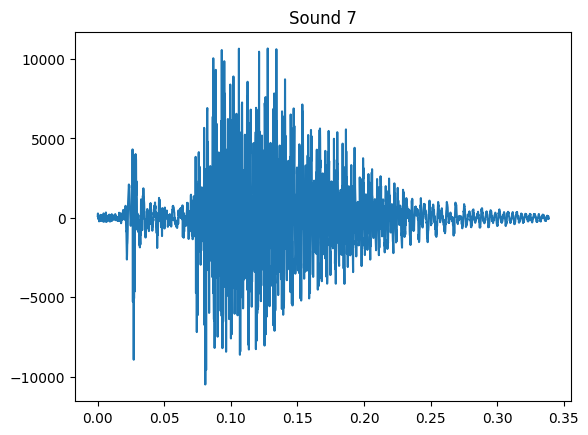

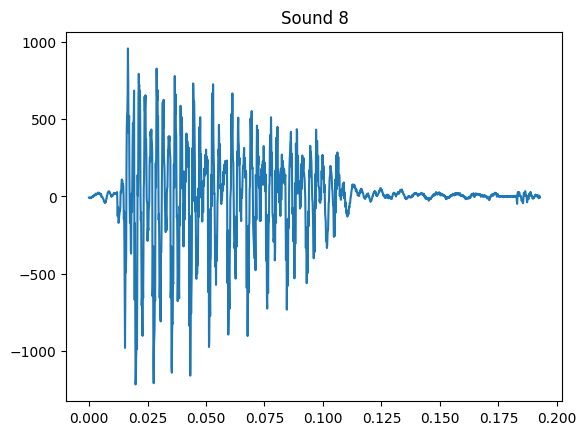

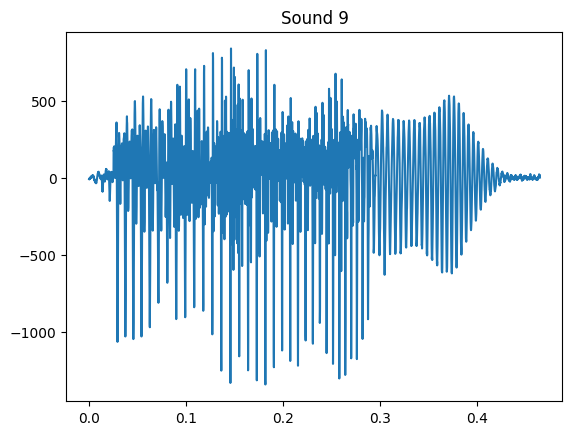

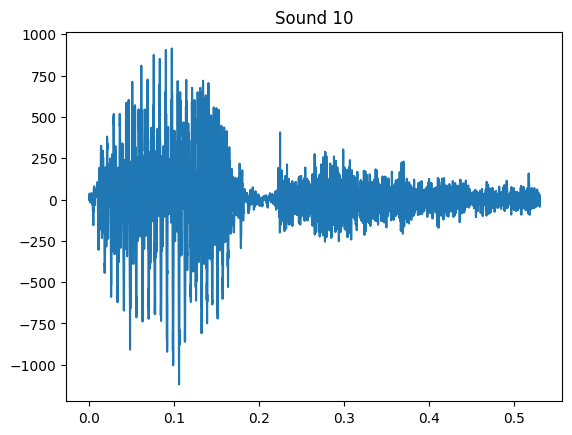

In [6]:
#sampling rate
sr = 8000 # the default for the dataset

#"visualise" (hear) some data
for i, ele in enumerate(ds.take(10)):
    display(Audio(ele,rate = sr,autoplay=True))
    time = np.linspace(0,ele.shape[0]/sr,ele.shape[0])
    plt.plot(time, ele)
    plt.title(f"Sound {i+1}")
    plt.show()

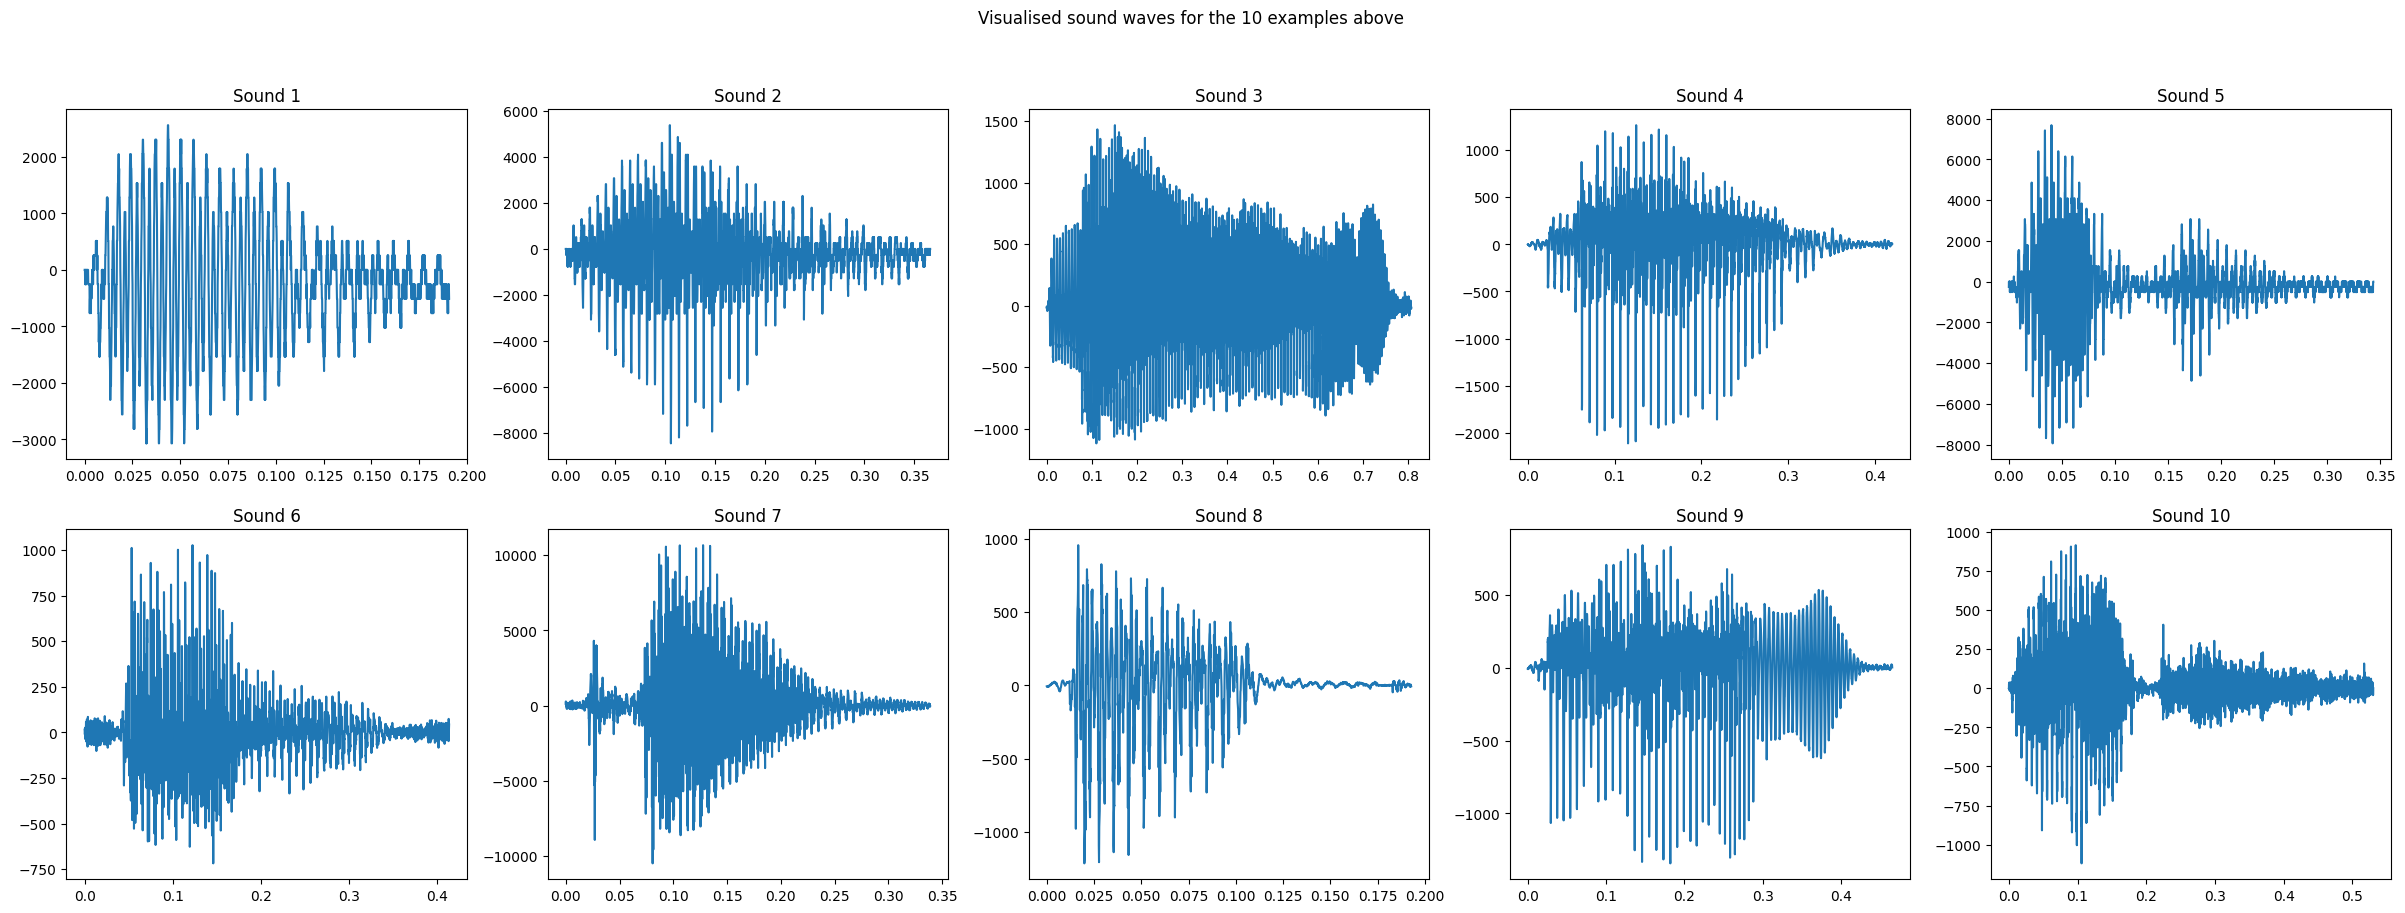

In [7]:
#now side by side for comparison
fig, axs = plt.subplots(nrows = 2, ncols = 5)
fig.set_figwidth(30)
fig.set_figheight(10)
for i, ele in enumerate(ds.take(10)):
    time = np.linspace(0,ele.shape[0]/sr,ele.shape[0])
    axs[i//5, i%5].plot(time, ele)
    axs[i//5, i%5].set_title(f"Sound {i+1}")
plt.suptitle("Visualised sound waves for the 10 examples above")
plt.show()

#clearly they need to be normalised

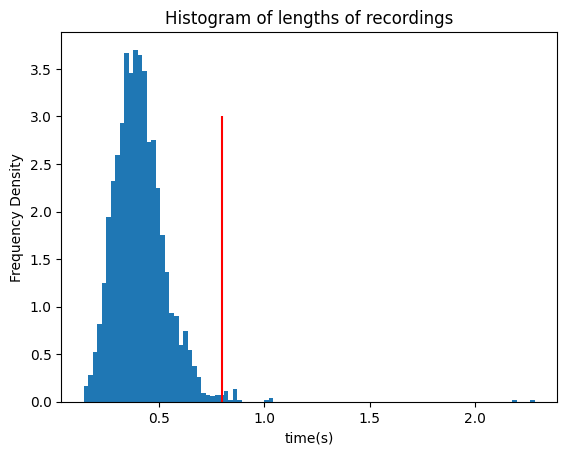

In [8]:
#investigate the lengths
def show_lengths(audio, rate = 8000):
    sample_times = [len(x)/rate for x in audio]
    plt.hist(x = sample_times, bins = 100, density = True)
    plt.xlabel("time(s)")
    plt.ylabel("Frequency Density")
    plt.title("Histogram of lengths of recordings")
    plt.vlines(x = 0.8, ymin = 0, ymax= 3,color = "red")
    plt.show()
    return sample_times

lengths = show_lengths(ds)

#redline is where we pad/cut the audio off


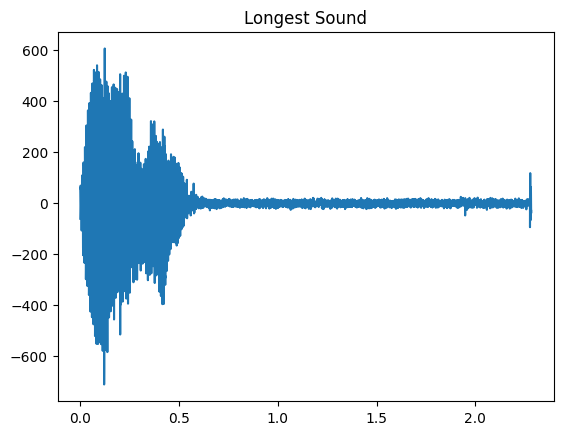

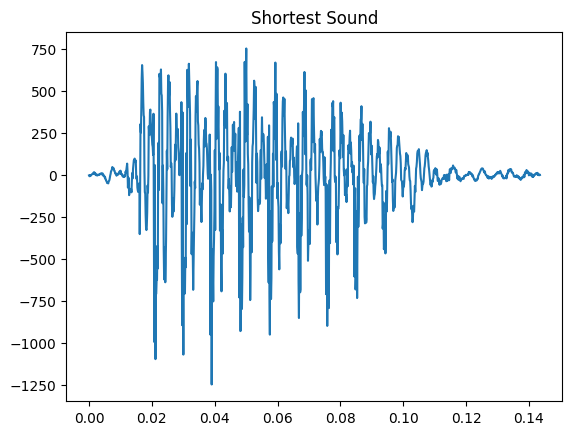

In [9]:
#find longest and shortest
la = np.argmax(lengths)
for i, ele in enumerate(ds.take(la+1)):
    if i == la:
        longest = ele
display(Audio(longest,rate = sr,autoplay=True))

time = np.linspace(0,len(longest)/sr,len(longest))
plt.plot(time, longest)
plt.title("Longest Sound")
plt.show()

#shortest
sa = np.argmin(lengths)
for i, ele in enumerate(ds.take(sa+1)):
    if i == sa:
        shortest = ele
display(Audio(shortest,rate = sr,autoplay=True))

time = np.linspace(0,len(shortest)/sr,len(shortest))
plt.plot(time, shortest)
plt.title("Shortest Sound")
plt.show()

In [10]:
#Based on the above lets make all audio the same length
max_len = int(0.8*sr) 
print(max_len)
def same_length(audio):
    audio = tf.cast(audio,tf.float32)
    len_aud = len(audio)
    if len_aud >= max_len:
        audio = audio[:max_len]
    else:
        holder = tf.zeros(shape = (max_len - len_aud,))
        audio = tf.concat((audio,holder),axis = 0)
    return audio

ds_uniform = ds.map(same_length)


6400


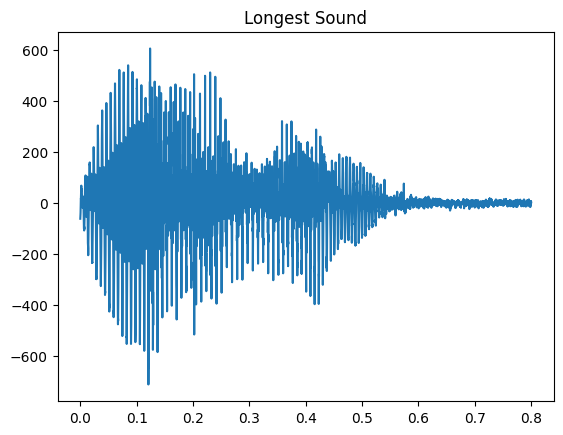

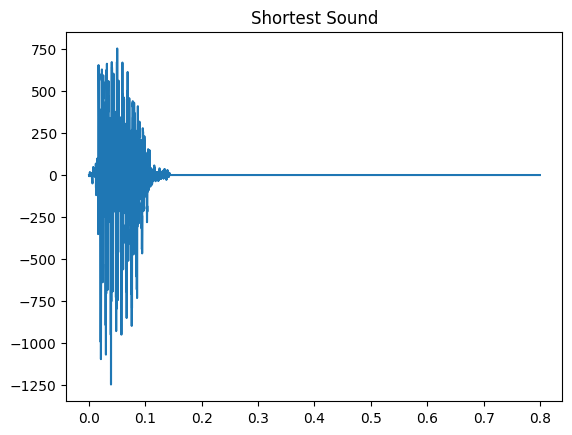

In [11]:
#same two sounds above but trimmed/extended:

for i, ele in enumerate(ds_uniform.take(la+1)):
    if i == la:
        longest = ele
display(Audio(longest,rate = sr,autoplay=True))

time = np.linspace(0,len(longest)/sr,len(longest))
plt.plot(time, longest)
plt.title("Longest Sound")
plt.show()

#shortest
sa = np.argmin(lengths)
for i, ele in enumerate(ds_uniform.take(sa+1)):
    if i == sa:
        shortest = ele
display(Audio(shortest,rate = sr,autoplay=True))

time = np.linspace(0,len(shortest)/sr,len(shortest))
plt.plot(time, shortest)
plt.title("Shortest Sound")
plt.show()

2500
tf.Tensor(0.020554561, shape=(), dtype=float32)


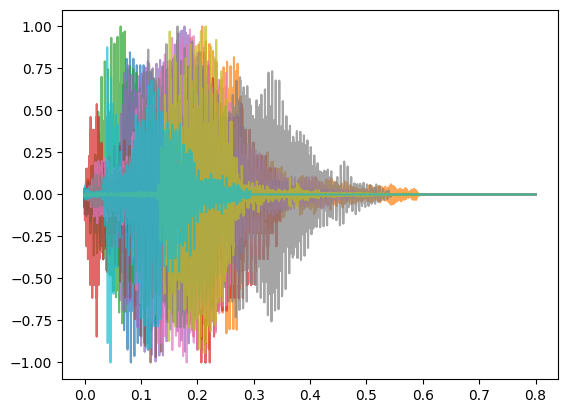

In [12]:
#we perform peak normalisation on the dataset (divide each wave by its max absolute peak value)

#peak normalisation
ds_uniform = ds_uniform.map(lambda t: t/tf.math.reduce_max(abs(t)))


#shuffle before splitting into training and validation sets for later
n = len(list(ds_uniform))
print(n)
ds_uniform = ds_uniform.shuffle(1000)

ds_uniform_train = ds_uniform.take(2000)
ds_uniform_val = ds_uniform.skip(2000)




#we will calculate the variance for later
### variance calc ###
n_ele = 0
sum_ele = 0
for ele in ds_uniform_train:
    sum_ele += tf.reduce_sum(ele)
    n_ele += tf.size(ele).numpy()
m = sum_ele/n_ele

sum_sq_diff = 0

for ele in ds_uniform_train:
    sum_sq_diff += tf.reduce_sum(tf.square(ele - m))

data_var = sum_sq_diff/n_ele
print(data_var)


#plot the first 10 normalised samples
for ele in ds_uniform.take(10):
    time = np.linspace(0,len(ele)/sr,len(ele))
    plt.plot(time, ele,alpha = 0.7)

#add a "channel" dimension and shuffle and batch and prefetch
ds_final = ds_uniform.map(lambda t: t[...,None]).shuffle(100).batch(128).prefetch(tf.data.AUTOTUNE)

ds_final_train = ds_uniform_train.map(lambda t: t[...,None]).shuffle(100).batch(128).prefetch(tf.data.AUTOTUNE)
ds_final_val = ds_uniform_val.map(lambda t: t[...,None]).shuffle(100).batch(128).prefetch(tf.data.AUTOTUNE)


In [13]:
### Alternative interpretation is to perform analysis via spectrograms ###

ds_uniform_spec = ds.map(same_length)

import tensorflow_io as tfio

def get_spectrogram(audio):
    spectrogram = tfio.audio.spectrogram(audio, nfft = 255, window = 128, stride = 50)
    return spectrogram

ds_spectrogram = ds_uniform.map(get_spectrogram) #(batch,128,128,1)

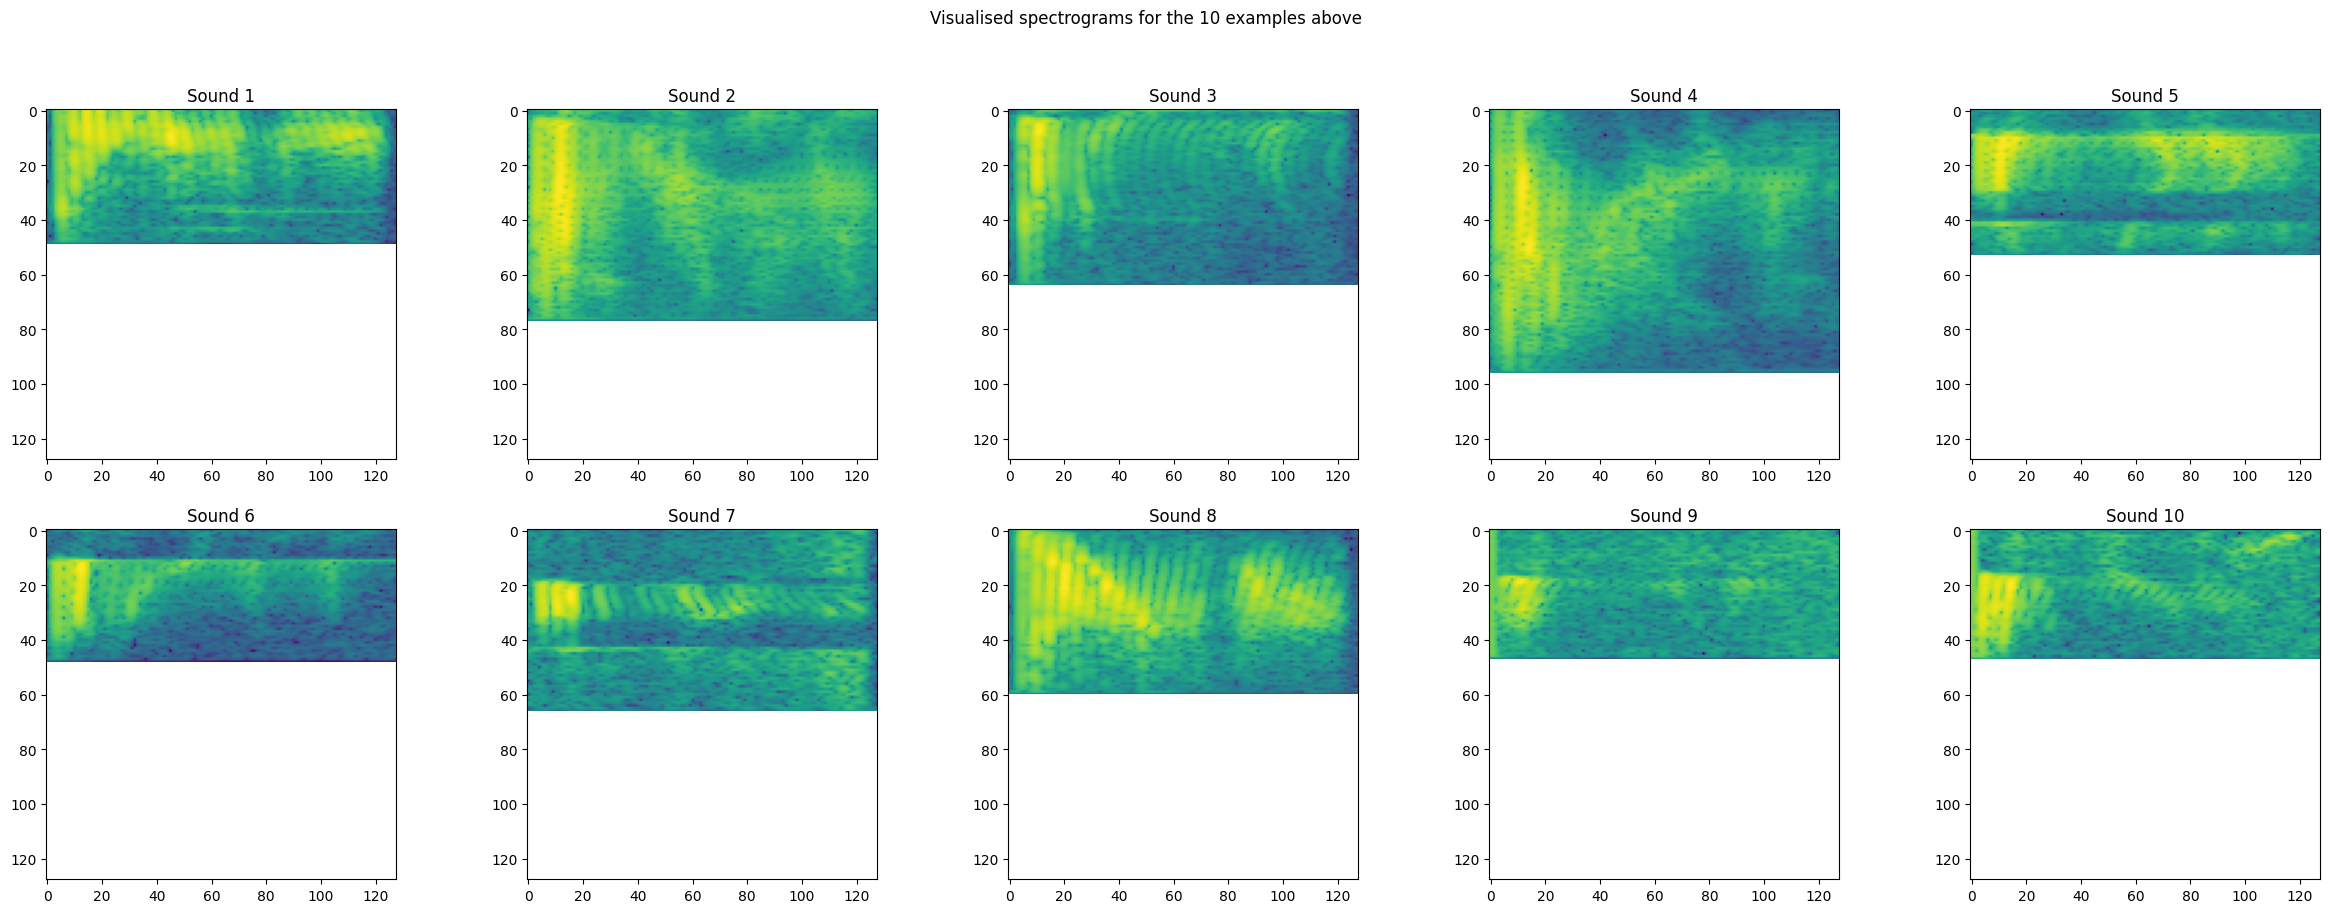

In [14]:
#plot the first 10 (log) spectograms

fig, axs = plt.subplots(nrows = 2, ncols = 5)
fig.set_figwidth(30)
fig.set_figheight(10)
for i, ele in enumerate(ds_spectrogram.take(10)):
    axs[i//5, i%5].imshow(tf.math.log(ele).numpy())
    axs[i//5, i%5].set_title(f"Sound {i+1}")
plt.suptitle("Visualised spectrograms for the 10 examples above")
plt.show()


#add a "channel" dimension and shuffle and batch and prefetch
ds_final_spec = ds_spectrogram.map(lambda t: t[...,None]).shuffle(100).batch(128).prefetch(tf.data.AUTOTUNE)

We see a variety of lengths of audio files. I made the decision to make all audio files the same length, and to perform peak normalisation on each one, so that they are constrained to [-1,1]. I also decided to do a second spectrogram-based approach, which is a way of converting the audio waves into "images" using phase information, however this is omitted due to it being sub-par.

### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

We choose a simple uniform distribution over the codebook vectors $e_i$, that is $p_\theta(z=e_i) = \frac{1}{K}$. Thus, looking at the KL-divergence term of the ELBO objective:
$$D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) = \int q_\phi({z}\mid{x})\log\left(\frac{q_\phi({z}\mid{x})}{p_\theta({z})}\right)d{z} =\sum_{i=1}^Kq_\phi({z=e_i}\mid{x})\log\left(\frac{q_\phi({z=e_i}\mid{x})}{p_\theta({z=e_i})}\right) = \sum_{i=1}^Kq_\phi({z=e_i}\mid{x})\log\left(Kq_\phi({z=e_i}\mid{x})\right) $$

For a given $x$, only one $i$ will be the argmin, since the $e_i$ are distinct. Let $i'$ be the index that is the argmin for the given $x$, then:

$$D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) = \sum_{i=1}^{i'-1}q_\phi({z=e_i}\mid{x})\log\left(Kq_\phi({z=e_i}\mid{x})\right)  + q_\phi({z=e_i'}\mid{x})\log(Kq_\phi({z=e_i'}\mid{x})) + \sum_{i=i'+1}^{K}q_\phi({z=e_i}\mid{x})\log\left(Kq_\phi({z=e_i}\mid{x})\right)$$

Then, setting $0\log(0) = 0$, we get:

$$D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) =  \log K$$

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [15]:
class RVQVectorQuantizer(Layer):
    def __init__(self,num_embeddings, embedding_dim, N_q, beta = 0.25, gamma = 0.99,training = False,**kwargs):
        '''
        num_embeddings is K above
        embedding dimension is D above
        N_q is the number of codebooks
        beta is beta above
        gamma is the decay parameter
        '''
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.n_q = N_q
        self.beta = beta
        self.gamma = gamma
        self.training = training
        
    def build(self, input_shape):
    #initialise the codebooks for each stage in the iteration
        w_init = tf.random_uniform_initializer(-0.001,0.001)
        self.codebooks = [tf.Variable(
            initial_value=w_init(
                shape=(self.num_embeddings, self.embedding_dim), dtype="float32"
            ),
            trainable=False, # because using EMA
            name=f"codebook {i}") for i in range(self.n_q)]# dimension N_q x K x D
        #initialise the Ns for each codebook:
        n_init = tf.constant_initializer(0)
        self.N = [tf.Variable(
            initial_value=n_init(
                shape = (self.num_embeddings,), dtype = "float32"
            ),
            trainable = False,
            name = f"n {i}") for i in range(self.n_q)]
        #initialise the ms for each codebook
        self.m = [tf.Variable(initial_value=self.codebooks[i].numpy(), trainable=False, name=f"m {i}") for i in range(self.n_q)]

    def call(self,y):
        '''
        y = E(x) is the output of the encoder. Dimension: batch x D
        works with batch
        '''
        residual = y
        residual_total = 0.0
        for j in range(self.n_q):
            #compute the distance between y and each row in the current codebook by expanding y dims
            #norm by default is euclidean
            distances = tf.norm(tf.expand_dims(residual,1) - self.codebooks[j], axis = -1)
            #find closest index for each batch
            closest_idx = tf.argmin(distances, axis = -1) # gives a vector which gives the index of the closest e for each member of the batch
            #get the corresponding closest vector
            closest_e = tf.gather(self.codebooks[j],closest_idx) # closest vector for each member of the batch
            
            #make the idx sequence for use in the prior later:
            if j == 0:
                idx_sequence = tf.expand_dims(closest_idx,1)
            else:
                idx_sequence = tf.concat([idx_sequence,tf.expand_dims(closest_idx,1)],axis = 1)

            ### Now to update the moving average if we are in the training phase
            if self.training:
                    
                    #find the number of vectors in the minibatch that are quantized to codebook vector e_i:
                    oh = tf.one_hot(closest_idx, self.num_embeddings, axis = -1) # one hot version, easier for summing over the rows
                    n_i = tf.reduce_sum(oh,axis = 0) #vector containing how many vectors in the minibatch are quantised to e_i in relative positions
                    #we only update the vectors that have been used
                    
                    n_i_flag = tf.where(tf.equal(n_i,0),True,False) 
                    #now for the m part, first, we need to cast correctly, which I tested separately
                    m_update = tf.matmul(tf.transpose(oh),residual)
                    
                    #update 
                    self.N[j].assign(self.N[j] * self.gamma + n_i * (1 - self.gamma))
                    self.m[j].assign(self.m[j] * self.gamma + m_update * (1 - self.gamma))

                    #only update the used codebook vectors
                    update = tf.where(n_i_flag[:,None], self.codebooks[j],self.m[j]/tf.expand_dims(self.N[j],axis = -1))

                    #now update codebooks, taking into account any zeros
                    self.codebooks[j].assign(update)

            #update residuals after training update due to how it is defined, so that the first update involves E(x) as stated above
            residual_total = residual_total + closest_e
            residual = residual - closest_e
            #loss
        committment_loss = tf.reduce_mean((tf.stop_gradient(residual_total) - y) ** 2)
        self.add_loss(self.beta * committment_loss)
        #straight through estimator
        residual_total = y + tf.stop_gradient(residual_total - y)
        return {"rt": residual_total, "sequence": idx_sequence}
    


c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

In [16]:

### THIS CELL WAS ADAPTED FROM THE KERAS VQVAE: https://keras.io/examples/generative/vq_vae/
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

x_train_scaled = tf.cast(x_train_scaled,tf.float32)

data_variance = np.var(x_train / 255.0)



train_dataset = tf.data.Dataset.from_tensor_slices(x_train_scaled)

train_dataset = train_dataset.shuffle(1000)

train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)



In [17]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, LayerNormalization
from keras import  Model

#This cell is adapted from the week 10 lecture notes

def get_encoder(latent_dim=16):
    encoder_inputs = Input(shape=(28, 28, 1))
    x = Conv2D(8, 5, activation="relu", padding="same")(encoder_inputs)
    x = MaxPool2D((2,2))(x)
    x = LayerNormalization()(x)
    x = Conv2D(8, 5, activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2))(x)
    x = LayerNormalization()(x)
    x = Conv2D(8, 5, activation='relu', padding="SAME")(x)
    x = Flatten()(x)
    x = LayerNormalization()(x)
    encoder_outputs = Dense(latent_dim, activation = "relu")(x)
    return Model(encoder_inputs, encoder_outputs, name="encoder")

def get_decoder(latent_dim=16):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(latent_inputs)
    x = Reshape((4, 4, 4))(x)
    x = Conv2D(16, (5, 5), padding="SAME", activation='relu')(x)
    x = Conv2DTranspose(8, (5, 5), strides=2, activation='relu', output_padding=1)(x)
    x = Conv2D(8, (5, 5), padding="SAME", activation='relu')(x)
    x = Conv2DTranspose(8, (3, 3), activation='relu')(x)
    x = Conv2D(8, (5, 5), padding="SAME", activation='relu')(x)
    x = Conv2DTranspose(8, (5, 5), padding="SAME", strides=2, activation='relu', output_padding=1)(x)
    decoder_outputs = Conv2D(1, 1, activation=None)(x)
    return Model(latent_inputs, decoder_outputs, name="decoder")





In [18]:

#again adapted from https://keras.io/examples/generative/vq_vae/

def get_vqvae(latent_dim=32, num_embeddings=128, N_q = 10):
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, N_q,training = True,name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)["rt"]
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 32)                16816     
                                                                 
 vector_quantizer (RVQVector  {'rt': (None, 32),       83200     
 Quantizer)                   'sequence': (None, 10)}            
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         12353     
                                                                 
Total params: 112,369
Trainable params: 29,169
Non-trainable params: 83,200
_________________________________________________________________


In [19]:
from keras.metrics import Mean


#adapted from https://keras.io/examples/generative/vq_vae/

class VQVAETrainer(Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, N_q=10, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings,N_q)

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [20]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


tf.keras.backend.clear_session()

es = EarlyStopping(monitor = "loss", patience = 10)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128,N_q = 20)
vqvae_trainer.compile(optimizer=Adam())
vqvae_trainer.fit(train_dataset, epochs=30, callbacks = [es])

Epoch 1/30
469/469 [==============================] - 11s 13ms/step - loss: 0.9976 - reconstruction_loss: 0.6506 - vqvae_loss: 0.0084
Epoch 2/30
469/469 [==============================] - 6s 12ms/step - loss: 0.3312 - reconstruction_loss: 0.3047 - vqvae_loss: 3.3870e-04
Epoch 3/30
469/469 [==============================] - 6s 13ms/step - loss: 0.2461 - reconstruction_loss: 0.2352 - vqvae_loss: 3.9656e-04
Epoch 4/30
469/469 [==============================] - 6s 12ms/step - loss: 0.2044 - reconstruction_loss: 0.1983 - vqvae_loss: 4.3333e-04
Epoch 5/30
469/469 [==============================] - 6s 13ms/step - loss: 0.1811 - reconstruction_loss: 0.1784 - vqvae_loss: 3.6330e-04
Epoch 6/30
469/469 [==============================] - 6s 13ms/step - loss: 0.1685 - reconstruction_loss: 0.1669 - vqvae_loss: 3.2962e-04
Epoch 7/30
469/469 [==============================] - 6s 12ms/step - loss: 0.1591 - reconstruction_loss: 0.1586 - vqvae_loss: 3.0028e-04
Epoch 8/30
469/469 [========================

1/1 [==============================] - 1s 925ms/step


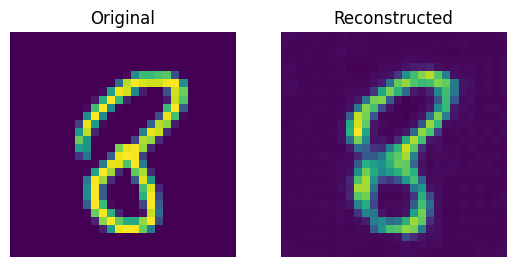

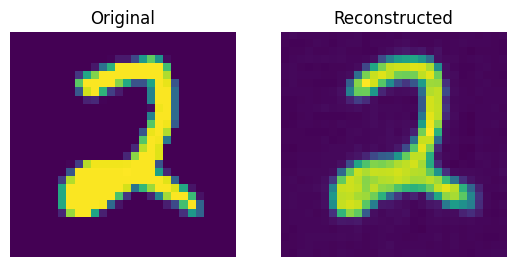

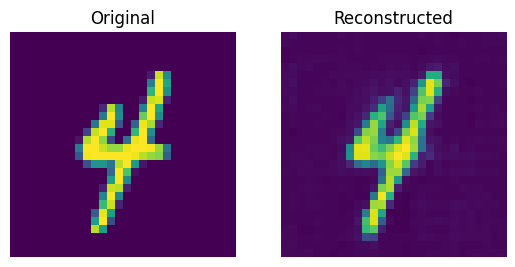

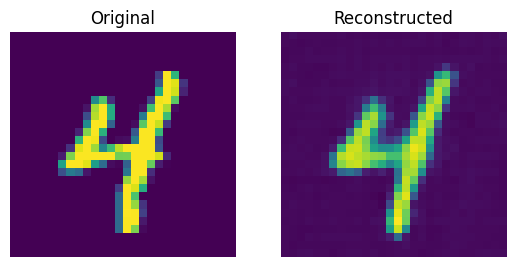

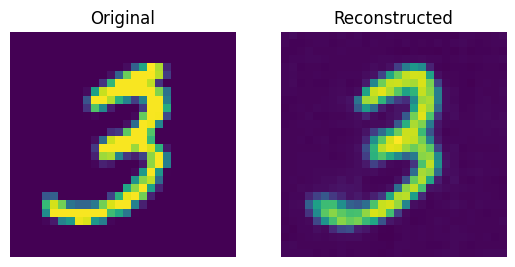

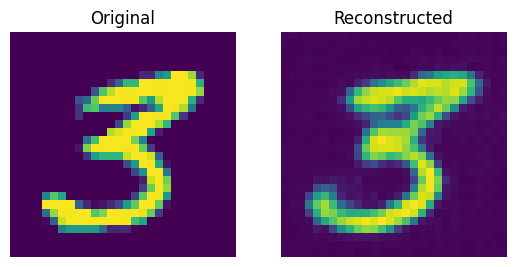

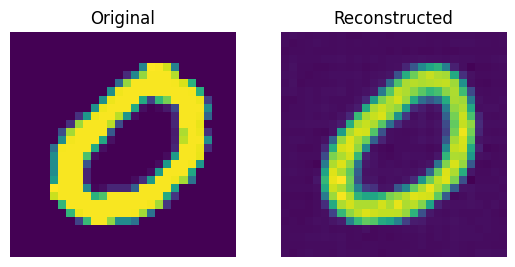

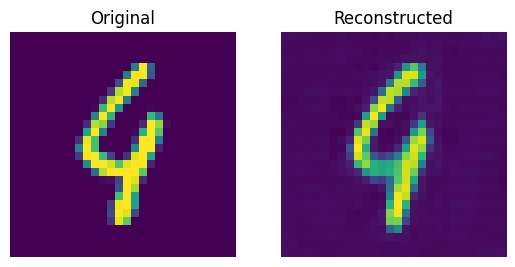

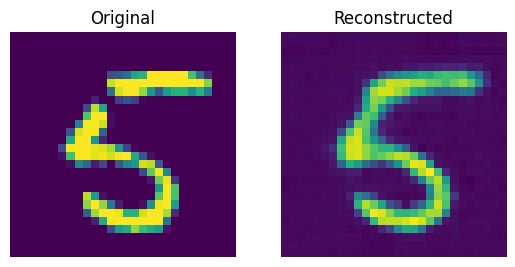

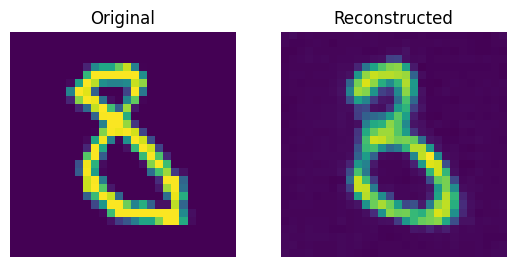

In [21]:
#adapted from https://keras.io/examples/generative/vq_vae/

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5 )
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

In [22]:
from keras.layers import Conv1D, GRU, Input, Flatten, BatchNormalization, ReLU, Dense

def get_encoder(latent_dim=128):
    encoder_inputs = Input(shape=(6400, 1))
    x = Conv1D(4, 4, strides = 2,padding="same",activation = "tanh")(encoder_inputs)
    x = BatchNormalization()(x)
    x = Conv1D(8, 4, strides = 2,padding="same",activation = "tanh")(x)
    x = BatchNormalization()(x)
    x = Conv1D(16, 4, strides = 2,padding="same",activation = "tanh")(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)

    encoder_outputs = Dense(latent_dim,activation = "tanh")(x)

    return Model(encoder_inputs, encoder_outputs, name="encoder")

In [23]:
from keras.layers import Conv1DTranspose, UpSampling1D


def get_decoder(latent_dim=128):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(12800,activation = "tanh")(latent_inputs)
    x = Reshape((-1,16))(x)
    x = Conv1DTranspose(16,4,2, padding = "same", activation = "tanh")(x)
    x = BatchNormalization()(x)
    x = Conv1DTranspose(8,4,2, padding = "same",activation = "tanh")(x)
    x = BatchNormalization()(x)
    x = Conv1DTranspose(4,4,2, padding = "same",activation = "tanh")(x)
    x = BatchNormalization()(x)
    x = Conv1D(1,1,1)(x)

    return Model(latent_inputs,x, name="decoder")

In [24]:
def get_vqvae(latent_dim=512, num_embeddings=512, N_q = 32):
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, N_q,training = True,name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = Input(shape=(6400,1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)["rt"]
    reconstructions = decoder(quantized_latents)
    return Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 6400, 1)]         0         
                                                                 
 encoder (Functional)        (None, 512)               6554908   
                                                                 
 vector_quantizer (RVQVector  {'rt': (None, 512),      16793600  
 Quantizer)                   'sequence': (None, 32)}            
                                                                 
 decoder (Functional)        (None, 6400, 1)           6568209   
                                                                 
Total params: 29,916,717
Trainable params: 13,123,005
Non-trainable params: 16,793,712
_________________________________________________________________


In [25]:
from keras.metrics import Mean


#adapted from https://keras.io/examples/generative/vq_vae/

class VQVAETrainer(Model):
    def __init__(self, train_variance,latent_dim=512, num_embeddings=512, N_q=32, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings,N_q)

        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = Mean(name="vq_loss")
        self.train_variance = train_variance

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            self.vqvae.training = True
            reconstructions = self.vqvae(x)
            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2)  / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)
        

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }
    def test_step(self, x):
        self.vqvae.training = False
        reconstructions = self.vqvae(x,training = False)
        reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2)  / self.train_variance
            )
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))
        self.total_loss_tracker.update_state(reconstruction_loss + sum(self.vqvae.losses))

        # Return a dict mapping metric names to current value
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [26]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

print(tf.config.list_physical_devices('GPU'))
tf.keras.backend.clear_session()

es = EarlyStopping(monitor = "val_loss", patience = 10)

#512 2048
vqvae_trainer = VQVAETrainer(train_variance=data_var,latent_dim=512, num_embeddings=512,N_q = 32)
vqvae_trainer.compile(optimizer=Adam())
history = vqvae_trainer.fit(ds_final_train,validation_data=ds_final_val,epochs=150,callbacks = [es])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/150
16/16 [==============================] - 5s 142ms/step - loss: 0.9774 - reconstruction_loss: 0.9850 - vqvae_loss: 0.0015 - val_loss: 0.9351 - val_reconstruction_loss: 0.9319 - val_vqvae_loss: 0.0032
Epoch 2/150
16/16 [==============================] - 1s 52ms/step - loss: 0.8334 - reconstruction_loss: 0.7982 - vqvae_loss: 0.0042 - val_loss: 0.6811 - val_reconstruction_loss: 0.6742 - val_vqvae_loss: 0.0069
Epoch 3/150
16/16 [==============================] - 1s 52ms/step - loss: 0.6676 - reconstruction_loss: 0.6501 - vqvae_loss: 0.0091 - val_loss: 0.5627 - val_reconstruction_loss: 0.5530 - val_vqvae_loss: 0.0096
Epoch 4/150
16/16 [==============================] - 1s 52ms/step - loss: 0.5679 - reconstruction_loss: 0.5529 - vqvae_loss: 0.0123 - val_loss: 0.4858 - val_reconstruction_loss: 0.4763 - val_vqvae_loss: 0.0095
Epoch 5/150
16/16 [==============================] - 1s 52ms/step - loss: 0.4934 - reconstru

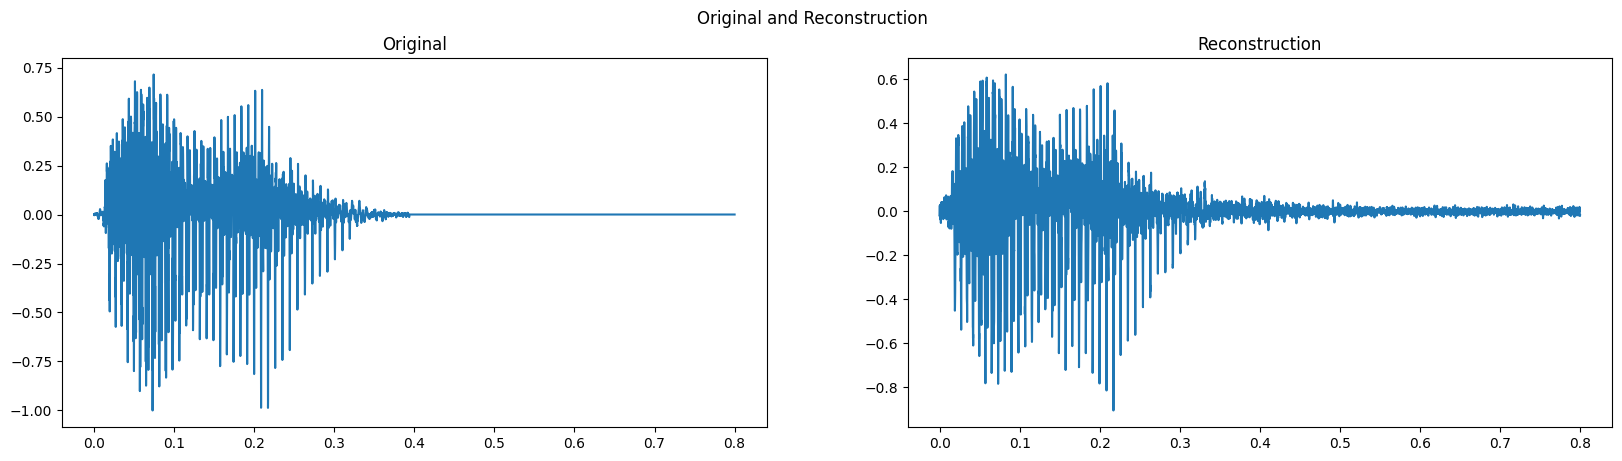

Original Audio:


Resconstruction


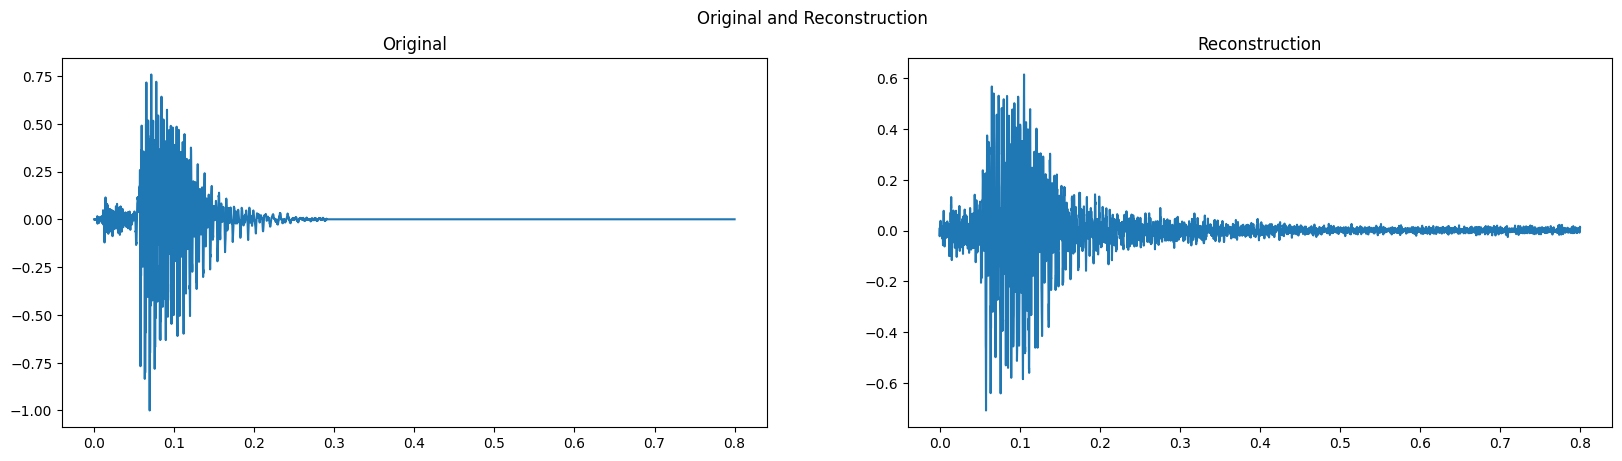

Original Audio:


Resconstruction


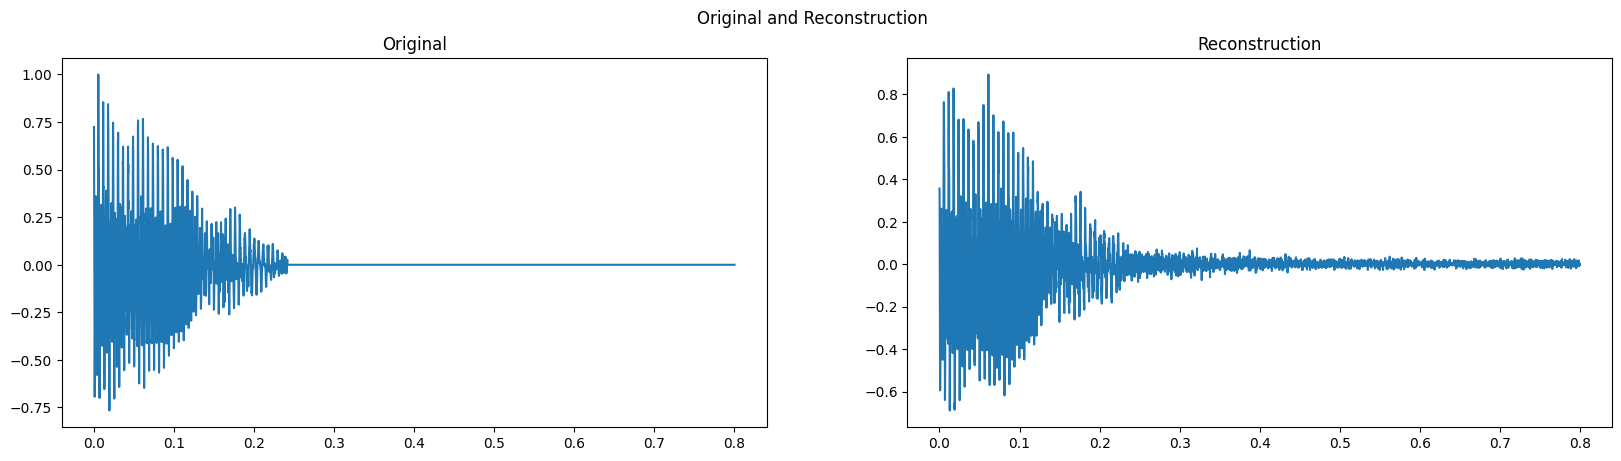

Original Audio:


Resconstruction


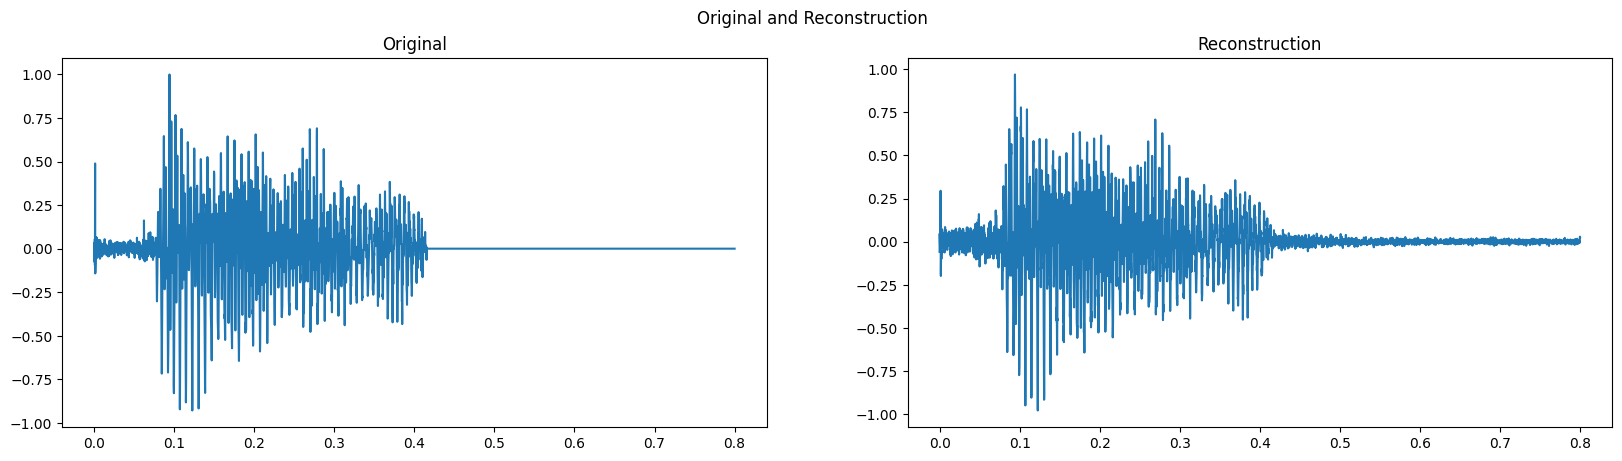

Original Audio:


Resconstruction


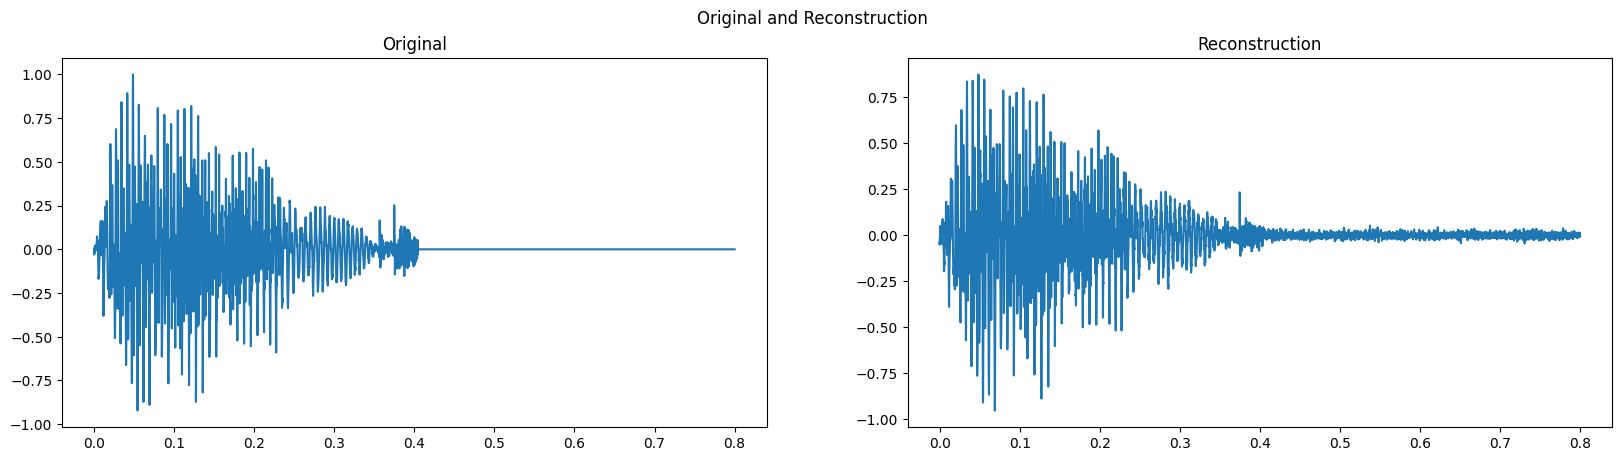

Original Audio:


Resconstruction


In [27]:

trained_vqvae_model = vqvae_trainer.vqvae
#set quantise layer to non training mode

trained_vqvae_model.get_layer("vector_quantizer").training = False

#we compare the reconstructions on the validation set
def compare(model,val_set,idx_list):

    for idx in idx_list:

        for ele in val_set.take(idx):
            orig = ele

        out = tf.squeeze(model(orig[None,...][...,None]))
        orig = tf.squeeze(orig)


        fig, axs = plt.subplots(nrows = 1, ncols = 2)
        fig.set_figwidth(20)
        time = np.linspace(0,orig.shape[0]/sr,orig.shape[0])
        axs[0].plot(time,orig)
        axs[0].set_title("Original")
        axs[1].plot(time,out)
        axs[1].set_title("Reconstruction")
        plt.suptitle("Original and Reconstruction")
        plt.show()

        print("Original Audio:")
        display(Audio(orig, rate = sr, autoplay=True))
        print("Resconstruction")
        display(Audio(out,rate = sr,autoplay=True))


compare(trained_vqvae_model,ds_uniform_val, [3,56,12,235,400] )

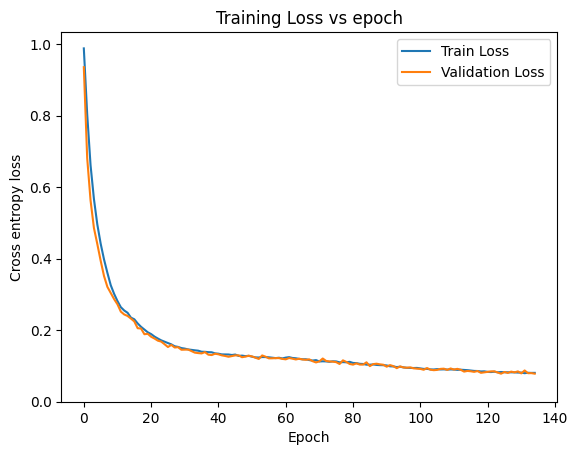

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Training Loss vs epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.show()

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors. 

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

In [29]:
#we use the encoder and decoder 

trained_vqvae_model = vqvae_trainer.vqvae 

encoder = trained_vqvae_model.get_layer("encoder")
rvq = trained_vqvae_model.get_layer("vector_quantizer")
rvq.training = False
decoder = trained_vqvae_model.get_layer("decoder")


In [30]:
from keras.layers import Dropout, MultiHeadAttention, LayerNormalization, Embedding


#needed for prediction at the end
def create_padding_mask(seq):
    # Create a mask to ignore paddings, assume padding is 0
    mask = tf.cast(tf.math.equal(seq, -1), tf.float32)
    # add extra dimensions to add the padding to the attention logits.
    return mask[:, tf.newaxis, tf.newaxis, :]


#taken from lectures
def positional_encodings(seq_len, d_model):
    max_wavelength = 10000.
    time = np.arange(seq_len)
    inx = np.arange(d_model)
    #make the grids, it is done element wise
    I, time = np.meshgrid(inx, time)
    pe_even = np.sin(time / max_wavelength**(I/d_model))
    pe_odd = np.cos(time / max_wavelength**(I/d_model))
    #put them in the right positions
    pe = np.zeros((seq_len, d_model))
    pe[:, ::2] = pe_even[:, ::2]
    pe[:, 1::2] = pe_odd[:, ::2]
    return tf.constant(pe, dtype=tf.float32)

def transformer_decoder(inputs, head_size, num_heads, ff_dim, dropout_rate, mask):
    """ A single transformer decoder layer. """
    # Masked Multi-head self-attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(inputs, inputs, attention_mask = mask, use_causal_mask = True)
    # Add & Norm
    attention_output = LayerNormalization(epsilon = 1e-6)(inputs + attention_output)
    # Feed-forward
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    # Add & Norm
    decoder_output = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention_output + ffn_output)
    return decoder_output


def build_transformer_model(input_vocab_size, seq_len,d_model, num_layers, num_heads, ff_dim, dropout_rate):
    """ Builds the decoder-only transformer. """
    inputs = Input(shape=(seq_len,))
    padding_mask = create_padding_mask(inputs)
    embedding_layer = Embedding(input_vocab_size, d_model)(inputs)
    pos_encoding = positional_encodings(seq_len, d_model)
    x = embedding_layer + pos_encoding
    for _ in range(num_layers):
        x = transformer_decoder(x, d_model // num_heads, num_heads, ff_dim, dropout_rate, padding_mask)
    #dense to output logits over "vocab"
    outputs = tf.keras.layers.Dense(input_vocab_size)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [31]:
# map the full dataset to sequences
ds_mapped = ds_uniform.map(lambda t: tf.squeeze(rvq(encoder(t[None,...]), training = False)["sequence"]), num_parallel_calls = tf.data.AUTOTUNE)

In [32]:
#save the mapped dataset to speed things up

path = "D:/University-local/Imperial/Term 2/Deep Learning/DL/Week 11/Week 11 Coursework/save_data"

tf.data.Dataset.save(ds_mapped, path)

In [33]:
ds_load =  tf.data.Dataset.load(path)
print(len(list(ds_load)))
#train and val
ds_load_train = ds_load.take(2000)
ds_load_val = ds_load.skip(2000)

2500


In [34]:
ds_mapped_train = ds_load_train.batch(128).prefetch(tf.data.AUTOTUNE)
ds_mapped_val = ds_load_val.batch(128).prefetch(tf.data.AUTOTUNE)


def inputs_and_targets(batch):
    inputs = batch[:,:-1]
    targets = batch[:,1:]
    return inputs, targets

ds_mapped_train = ds_mapped_train.map(inputs_and_targets)
ds_mapped_val = ds_mapped_val.map(inputs_and_targets)

for ele in ds_mapped_train.take(1):
    print(ele[0].shape)

(128, 31)


In [35]:
es = EarlyStopping(monitor ="val_loss", patience = 10)
losses = [tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),None]

tf.keras.backend.clear_session()
#(input_vocab_size, seq_len,d_model, num_layers, num_heads, ff_dim, dropout_rate)
prior = build_transformer_model(512,31,512,4,6,512,0.1)
prior.compile(optimizer= Adam(learning_rate = 0.0001), 
                metrics=[['sparse_categorical_accuracy'],[] ],
                loss=losses)
prior.fit(ds_mapped_train, epochs = 100, validation_data= ds_mapped_val,callbacks = [es])

Epoch 1/100
16/16 [==============================] - 4s 65ms/step - loss: 5.1082 - sparse_categorical_accuracy: 0.1039 - val_loss: 4.1751 - val_sparse_categorical_accuracy: 0.2117
Epoch 2/100
16/16 [==============================] - 1s 36ms/step - loss: 3.7109 - sparse_categorical_accuracy: 0.2726 - val_loss: 3.4046 - val_sparse_categorical_accuracy: 0.2868
Epoch 3/100
16/16 [==============================] - 1s 35ms/step - loss: 3.1536 - sparse_categorical_accuracy: 0.2969 - val_loss: 3.0434 - val_sparse_categorical_accuracy: 0.2917
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 2.8784 - sparse_categorical_accuracy: 0.2989 - val_loss: 2.8545 - val_sparse_categorical_accuracy: 0.2943
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 2.7289 - sparse_categorical_accuracy: 0.3004 - val_loss: 2.7466 - val_sparse_categorical_accuracy: 0.2955
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 2.6388 - sparse_categorica

Generated sequence: [  0 116  46 367 160 266 478  20 122 117 214 475 249 144 503 385 481 306
 172 135 370 308 143 214 387  12 124 240 380  72 375  83]


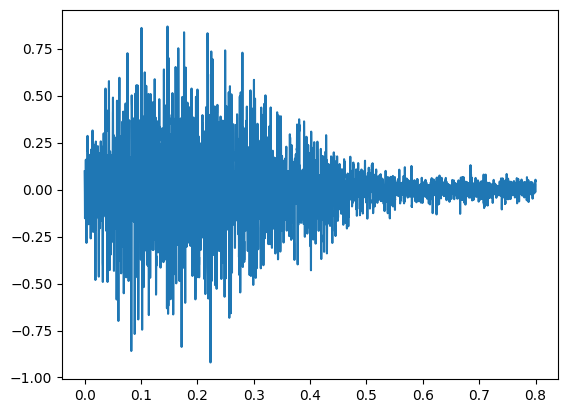

Generated sequence: [ 13 506 161  93 260 105 110 191 257 197 113  15 182 241 178 489 481 172
 413 135 370 265 471 134 387  12 144  73 252  79 435  55]


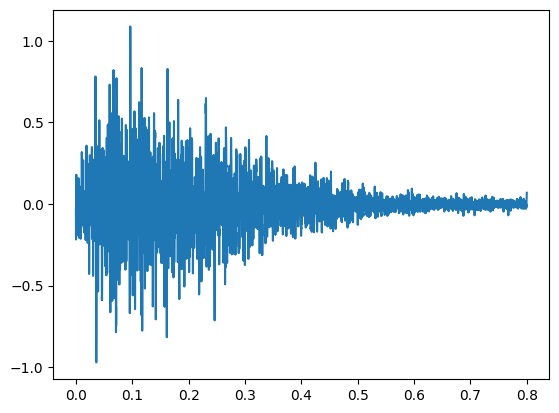

Generated sequence: [ 32  71 410 154 404 196 402 357 325  40 323 448 411  78 511 489 481 403
 172 357  25  91 499 214 387 456 124  73 252  79 435 162]


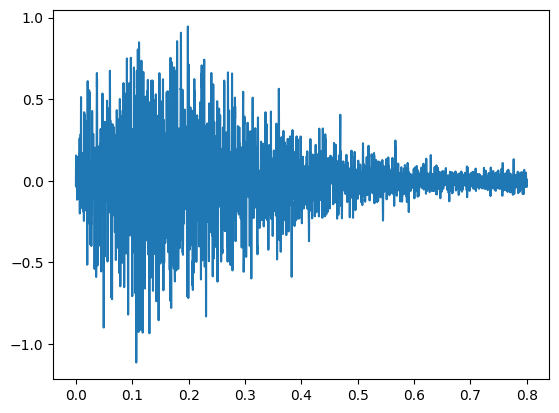

Generated sequence: [ 51 388   5 460 443 276 110 206 152 190  67 430  17  82 503 385 228 190
 222 135 370 281 143 214 387 456 493 240 241 401 402 382]


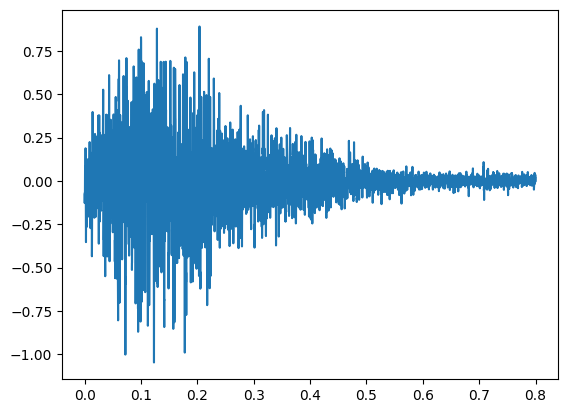

Generated sequence: [265 417 251 327 302 266 243  57 427 373 127 421  25   9 140 489 397 249
 172 172 208  91 251  95 387 456 379 240 252 502 161  55]


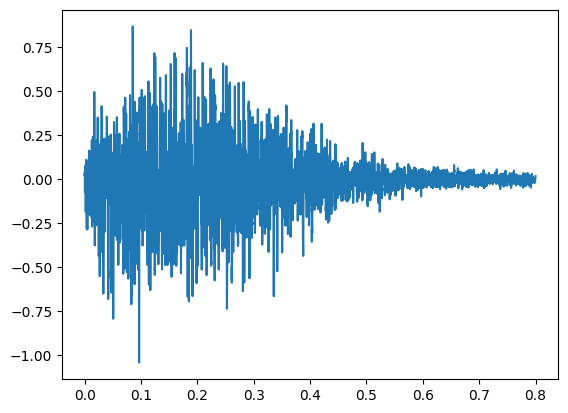

In [36]:
def sample_from_prior(prior_model, start_token, max_len):

    generated_sequence = np.array([start_token])

    for _ in range(max_len-1):
        curr_len = len(generated_sequence)
        
        #we choose -1 as our padding token, since 0 is used
        padded_sequence = np.concatenate([generated_sequence, np.repeat([-1],max_len-1-curr_len)])
        logits = prior_model(tf.expand_dims(padded_sequence, 0))
     
   
        logits = logits[:, curr_len-1, :]  # Get the logits for the current time step
        # Sample from the logits
        next_token =tf.random.categorical(logits, num_samples=1, dtype=tf.int32)
        next_token = next_token.numpy()[0]
    
        generated_sequence = np.concatenate([generated_sequence,next_token])

        if next_token == -1:  # End token
            break

    return generated_sequence


def sample_audio(decoder, seq):
    #get actual rv sequence
    residual_sum = 0.0
    for i, token in enumerate(seq):

        residual_sum += rvq.codebooks[i][token]
    return decoder(residual_sum[None,...])


max_len = 32

# Example usage
start_tokens = [0,13,32,51,265]

for token in start_tokens:



    generated_sequence = sample_from_prior(prior, token, max_len)
    print("Generated sequence:", generated_sequence)

    samp = tf.squeeze(sample_audio(decoder,generated_sequence))
    display(Audio(samp, rate = sr, autoplay=True))

    time = np.linspace(0,samp.shape[0]/sr,samp.shape[0])
    plt.plot(time,samp)
    plt.show()



### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**